#model

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os


INIT_LR = 1e-4
EPOCHS = 20
BS = 32

DIRECTORY = r"/content/drive/MyDrive/helmet_detect_repo"
CATEGORIES = ["with_helmet", "woh"]

In [ ]:
# grab the list of images in our dataset directory, then initialize
# the list of data (i.e., images) and class images

data = []
labels = []

for category in CATEGORIES:
    path = os.path.join(DIRECTORY, category)
    for img in os.listdir(path):
    	img_path = os.path.join(path, img)
    	image = load_img(img_path, target_size=(224, 224))
    	image = img_to_array(image)
    	image = preprocess_input(image)

    	data.append(image)
    	labels.append(category)

# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

data = np.array(data, dtype="float32")
labels = np.array(labels)

(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, stratify=labels, random_state=42)

# construct the training image generator for data augmentation
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

In [ ]:
baseModel = MobileNetV2(weights="imagenet", include_top=False,
                        input_tensor=Input(shape=(224, 224, 3)))

#HeadModel
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

#Connecting both base and head models
model = Model(inputs=baseModel.input, outputs=headModel)

#freezing base layer weights
for layer in baseModel.layers:
	layer.trainable = False

# compile our model
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

9412608/9406464 [==============================] - 0s 0us/step
[INFO] compiling model...


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
#finetuneing
print("[INFO] training head...")
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)


print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)


predIdxs = np.argmax(predIdxs, axis=1)


print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))

#save to drive

model.save("helmet_detector.model", save_format="h5")




[INFO] training head...
Epoch 1/20
82/82 [==============================] - 57s 310ms/step - loss: 0.3682 - accuracy: 0.8590 - val_loss: 0.1306 - val_accuracy: 0.9848
Epoch 2/20
82/82 [==============================] - 24s 296ms/step - loss: 0.1256 - accuracy: 0.9681 - val_loss: 0.0578 - val_accuracy: 0.9924
Epoch 3/20
82/82 [==============================] - 24s 296ms/step - loss: 0.0685 - accuracy: 0.9877 - val_loss: 0.0328 - val_accuracy: 0.9939
Epoch 4/20
82/82 [==============================] - 25s 300ms/step - loss: 0.0564 - accuracy: 0.9862 - val_loss: 0.0231 - val_accuracy: 0.9970
Epoch 5/20
82/82 [==============================] - 24s 296ms/step - loss: 0.0450 - accuracy: 0.9885 - val_loss: 0.0152 - val_accuracy: 0.9985
Epoch 6/20
82/82 [==============================] - 24s 297ms/step - loss: 0.0394 - accuracy: 0.9919 - val_loss: 0.0113 - val_accuracy: 1.0000
Epoch 7/20
82/82 [==============================] - 25s 300ms/step - loss: 0.0283 - accuracy: 0.9931 - val_loss: 0.012

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


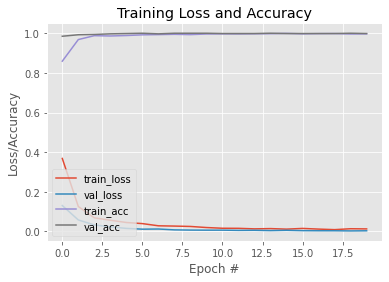

In [ ]:
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")

# for using webcam

In [ ]:
#https://colab.research.google.com/github/vindruid/yolov3-in-colab/blob/master/yolov3_streaming_webcam.ipynb

import base64
import html
import io
import time

from IPython.display import display, Javascript
from google.colab.output import eval_js
import numpy as np
from PIL import Image
import cv2


def start_input():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 512, 512);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 512; //video.videoWidth;
      captureCanvas.height = 512; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function takePhoto(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def take_photo(label, img_data):
  data = eval_js('takePhoto("{}", "{}")'.format(label, img_data))
  return data

def js_reply_to_image(js_reply):
    """
    input: 
          js_reply: JavaScript object, contain image from webcam

    output: 
          image_array: image array RGB size 512 x 512 from webcam
    """
    jpeg_bytes = base64.b64decode(js_reply['img'].split(',')[1])
    image_PIL = Image.open(io.BytesIO(jpeg_bytes))
    image_array = np.array(image_PIL)

    return image_array

#testing Model

In [ ]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
import numpy as np
import imutils
import time
import cv2
import os
from google.colab.patches import cv2_imshow

In [ ]:
def detect_and_predict(frame, faceNet, maskNet):
	(h, w) = frame.shape[:2]
	blob = cv2.dnn.blobFromImage(frame, 1.0, (224, 224),
		(104.0, 177.0, 123.0))

	# pass the blob through the network and obtain the face detections
	faceNet.setInput(blob)
	detections = faceNet.forward()
	print(detections.shape)

	faces = []
	locs = []
	preds = []

	# loop over the detections
	for i in range(0, detections.shape[2]):
		confidence = detections[0, 0, i, 2]

		if confidence > 0.2:
			# compute the (x, y)-coordinates of the bounding box for
			# the object
			box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
			(startX, startY, endX, endY) = box.astype("int")

			# ensure the bounding boxes fall within the dimensions of
			# the frame
			(startX, startY) = (max(0, startX), max(0, startY))
			(endX, endY) = (min(w - 1, endX), min(h - 1, endY))

			# extract the face ROI, convert it from BGR to RGB channel
			# ordering, resize it to 224x224, and preprocess it
			face = frame[startY:endY, startX:endX]
			face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
			face = cv2.resize(face, (224, 224))
			face = img_to_array(face)
			face = preprocess_input(face)

			# add the face and bounding boxes to their respective
			# lists
			faces.append(face)
			locs.append((startX, startY, endX, endY))

	# only make a predictions if at least one face was detected
	if len(faces) > 0:
		# for faster inference we'll make batch predictions on *all*
		# faces at the same time rather than one-by-one predictions
		# in the above `for` loop
		faces = np.array(faces, dtype="float32")
		preds = maskNet.predict(faces, batch_size=32)

	# return a 2-tuple of the face locations and their corresponding
	# locations
	return (locs, preds)



[INFO] starting video stream...


<IPython.core.display.Javascript object>

(1, 1, 200, 7)


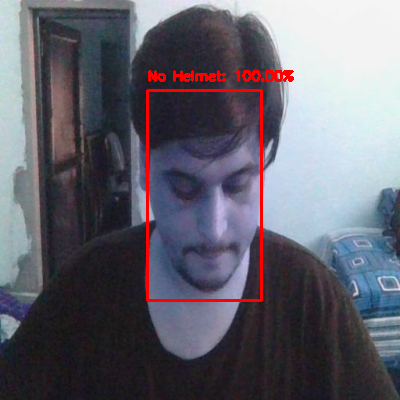

(1, 1, 200, 7)


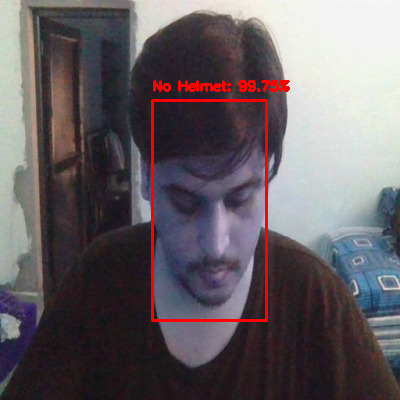

(1, 1, 200, 7)


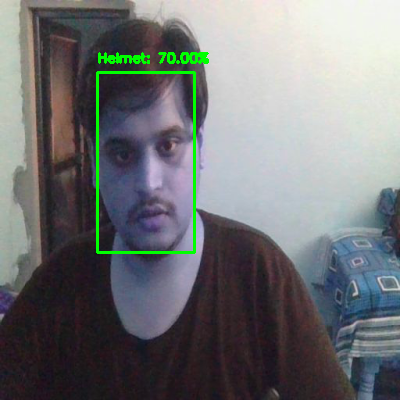

(1, 1, 200, 7)


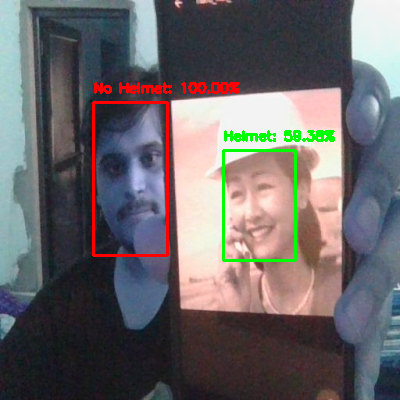

(1, 1, 200, 7)


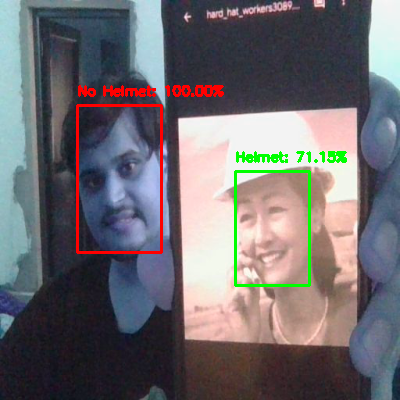

(1, 1, 200, 7)


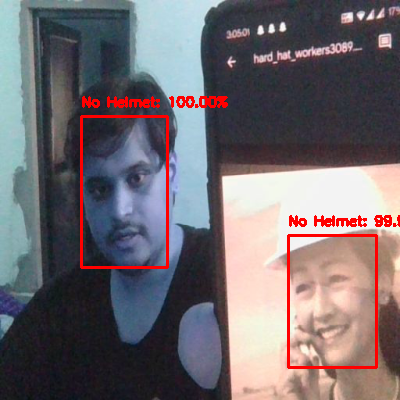

(1, 1, 200, 7)


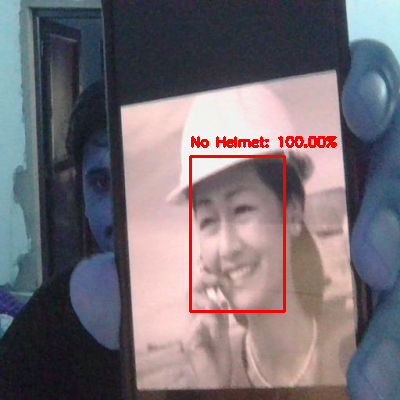

In [ ]:
# load our serialized face detector model from disk
prototxtPath = r"/content/drive/MyDrive/helmet_detect_repo/deploy.prototxt"
weightsPath = r"/content/drive/MyDrive/helmet_detect_repo/res10_300x300_ssd_iter_140000.caffemodel"
faceNet = cv2.dnn.readNet(prototxtPath, weightsPath)

# load the helmet detector model from disk
maskNet = load_model("helmet_detector.model")


label_html = 'Capturing...'
img_data = ''

# initialize the video stream
print("[INFO] starting video stream...")
#vs = VideoStream(src=0).start()

start_input()
#vs = take_photo(label_html, img_data)

# loop over the frames from the video stream
while True:
	# grab the frame from the threaded video stream and resize it
	# to have a maximum width of 400 pixels
	#frame = vs.read()
	#frame = imutils.resize(frame, width=400)
  js_reply = take_photo(label_html, img_data)
  if not js_reply:
    break

  frame = js_reply_to_image(js_reply)
  #frame = take_photo(label_html, img_data)
  frame = imutils.resize(frame, width=400)

	# detect faces in the frame and determine if they are wearing a
	# hard hat or not
  (locs, preds) = detect_and_predict(frame, faceNet, maskNet)

	# loop over the detected face locations and their corresponding
	# locations
  for (box, pred) in zip(locs, preds):
    # unpack the bounding box and predictions
    (startX, startY, endX, endY) = box
    (helmet, withoutHelmet) = pred
    
		# determine the class label and color we'll use to draw
		# the bounding box and text
    label = "Helmet" if helmet >=0.2 else "No Helmet"
    color = (0, 255, 0) if label == "Helmet" else (0, 0, 255)
    
    # include the probability in the label
    label = "{}: {:.2f}%".format(label, max(helmet, withoutHelmet) * 100)

		# display the label and bounding box rectangle on the output
		# frame
    cv2.putText(frame, label, (startX, startY - 10),
			cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
    cv2.rectangle(frame, (startX, startY), (endX, endY), color, 2)

	# show the output frame
  cv2_imshow(frame)
  key = cv2.waitKey(1) & 0xFF

  # if the `q` key was pressed, break from the loop
  if key == ord("q"):
    break

# do a bit of cleanup
cv2.destroyAllWindows()
#vs.stop()